原始数据统计信息：
数据点数量: 782
平均值: 54610.7959
标准差: 1078.8563




d:\software\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


预测结果：
短期预测（未来30天）前5个值：
[1.931533   1.91225826 1.91725635 1.85061386 1.86700612]

长期预测（未来12个月）前5个值：
[1.90960358 1.91634733 1.90456876 1.89615036 1.88564436]




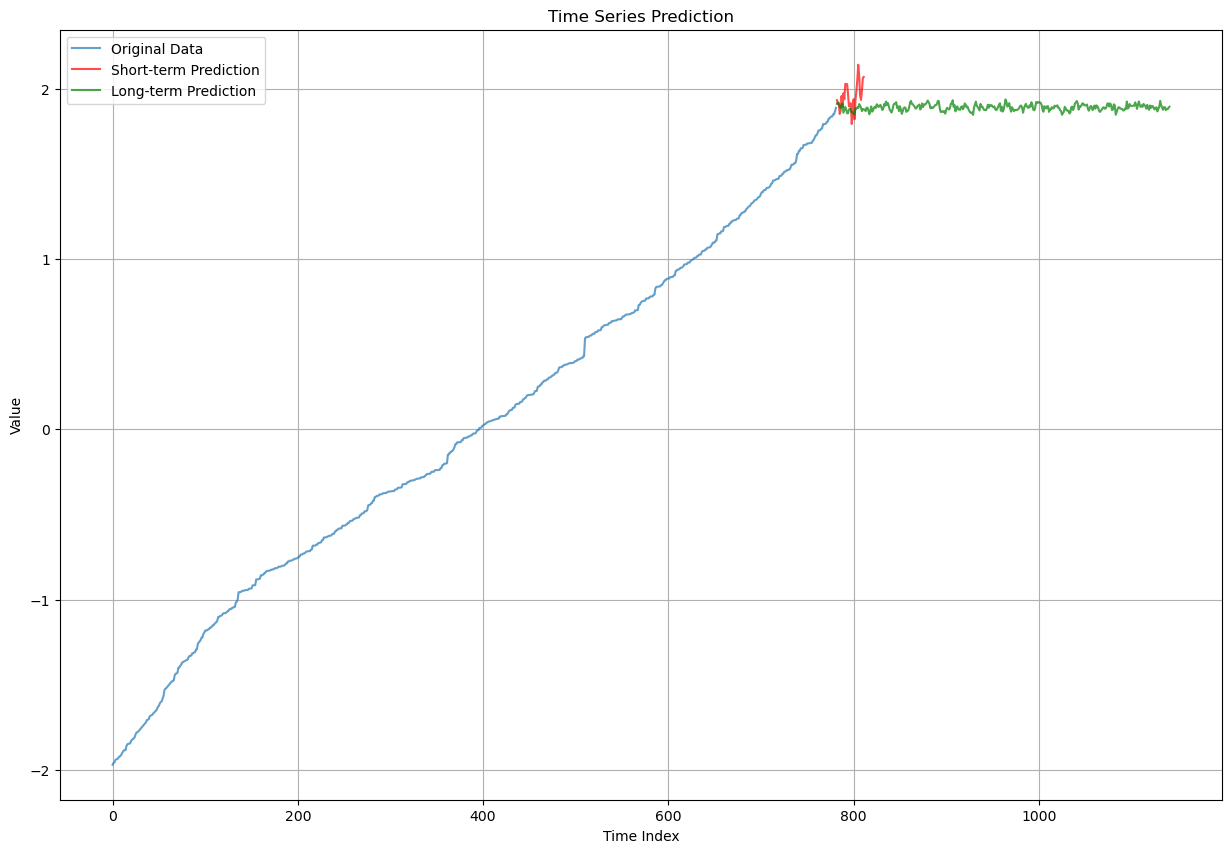

d:\software\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


预测评估指标：
MSE: 0.0003
RMSE: 0.0171
MAE: 0.0146


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
# 读取Excel文件
df = pd.read_excel('Attachment 1.xlsx')  # 跳过前两行
data = pd.to_numeric(df.iloc[:,1], errors='coerce').dropna().values  # 获取第二列数据


# 数据标准化/归一化
data_normalized = (data - np.mean(data)) / np.std(data)

# 可以使用多种方法进行预测
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def generate_red_noise(N, dt=1.0, P0=1.0, fc=1.0, q=2.0):
    """
    生成红噪声时间序列
    
    参数:
    N: int, 需要生成的数据点数
    dt: float, 时间步长
    P0: float, 功率谱密度在f=0时的值
    fc: float, 转折频率
    q: float, 频谱指数
    
    返回:
    numpy array: 生成的红噪声时间序列
    """
    # 生成频率数组
    freq = np.fft.fftfreq(N, dt)
    
    # 避免除以零
    freq[0] = 1e-10
    
    # 生成功率谱
    power = P0 / (1.0 + np.abs(freq/fc)**q)
    

    
    # 生成随机相位
    phase = 2 * np.pi * np.random.random(N)
    
    # 生成傅里叶分量
    fourier = np.sqrt(power) * np.exp(1j * phase)
    
    # 进行逆傅里叶变换得到时间序列
    noise = np.fft.ifft(fourier).real
    
    return noise

def load_and_preprocess_data(file_path):
    try:
        # 读取Excel文件，明确指定没有表头
        df = pd.read_excel(file_path, header=None)
        print(f"原始数据形状: {df.shape}")
        
        # 只保留前两列并重命名
        df = df.iloc[:, [0, 1]]
        df.columns = ['MJD', 'PT-TT']
        
        # 确保数据为数值类型
        df['MJD'] = pd.to_numeric(df['MJD'], errors='coerce')
        df['PT-TT'] = pd.to_numeric(df['PT-TT'], errors='coerce')
        
        # 删除任何包含NaN的行
        df = df.dropna()
        
        print(f"处理后数据形状: {df.shape}")
        print("数据类型:")
        print(df.dtypes)
        print("\n数据预览:")
        print(df.head())
        
        return df
        
    except Exception as e:
        print(f"数据加载错误: {str(e)}")
        return None


def optimize_parameters(data):
    # 这里是一个简单的示例实现
    # 您可以根据实际需求修改参数优化方法
    P0 = np.var(data)  # 使用数据方差作为功率谱密度
    fc = 0.1  # 转折频率
    q = 2.0   # 频谱指数
    return P0, fc, q
# 短期预测 (ARIMA模型)
def short_term_prediction(data, days=30):
    model = ARIMA(data, order=(1,1,1))
    results = model.fit()
    forecast = results.forecast(steps=days)
    return forecast

# 长期预测 (指数平滑)
def long_term_prediction(data, months=12):
    model = ExponentialSmoothing(data)
    results = model.fit()
    forecast = results.forecast(steps=months*30)  # 假设每月30天
    return forecast

from scipy.fft import fft, ifft, fftfreq

# ... existing code ...

def generate_red_noise_prediction(data, length):
    # 使用optimize_parameters获取参数
    P0, fc, q = optimize_parameters(data)
    # 生成红噪声，使用固定的dt=1作为采样间隔
    noise = generate_red_noise(length, dt=1, P0=P0, fc=fc, q=q)
    return noise

def combined_prediction(data, short_term_days=30, long_term_months=12):
    # 短期预测
    short_pred = short_term_prediction(data, short_term_days)
    
    # 长期预测
    long_pred = long_term_prediction(data, long_term_months)
    
    # 红噪声预测
    noise_short = generate_red_noise_prediction(data, short_term_days)
    noise_long = generate_red_noise_prediction(data, long_term_months*30)
    
    # 组合预测结果
    final_short = short_pred + noise_short
    final_long = long_pred + noise_long
    
    return final_short, final_long




def plot_predictions(data, short_pred, long_pred):
    plt.figure(figsize=(15, 10))
    
    # 确保所有数据都是数值类型
    mjd = data.index.astype(float) if isinstance(data, pd.Series) else np.arange(len(data))
    
    # 绘制原始数据
    plt.plot(mjd, data, label='Original Data', alpha=0.7)
    
    # 为预测创建时间索引
    pred_index = np.arange(len(mjd), len(mjd) + len(short_pred))
    long_pred_index = np.arange(len(mjd), len(mjd) + len(long_pred))
    
    # 绘制预测
    plt.plot(pred_index, short_pred, label='Short-term Prediction', color='red', alpha=0.7)
    plt.plot(long_pred_index, long_pred, label='Long-term Prediction', color='green', alpha=0.7)
    
    plt.legend()
    plt.title('Time Series Prediction')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
def evaluate_prediction(true_values, predicted_values):
    mse = np.mean((true_values - predicted_values)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true_values - predicted_values))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # ... existing code ...

# 执行预测并显示结果
if __name__ == "__main__":
    # 1. 显示原始数据的基本统计信息
    print("原始数据统计信息：")
    print(f"数据点数量: {len(data)}")
    print(f"平均值: {np.mean(data):.4f}")
    print(f"标准差: {np.std(data):.4f}")
    print("\n")

    # 2. 进行预测
    short_pred, long_pred = combined_prediction(data_normalized)
    
    # 3. 显示预测结果
    print("预测结果：")
    print(f"短期预测（未来30天）前5个值：")
    print(short_pred[:5])
    print("\n长期预测（未来12个月）前5个值：")
    print(long_pred[:5])
    print("\n")

    # 4. 绘制预测图
    plot_predictions(data_normalized, short_pred, long_pred)

    # 5. 如果要评估预测效果（假设我们用最后30天的数据作为测试集）
    test_size = 30
    train_data = data_normalized[:-test_size]
    test_data = data_normalized[-test_size:]
    
    # 对测试数据进行预测
    short_pred_test = short_term_prediction(train_data, days=test_size)
    
    # 评估预测效果
    metrics = evaluate_prediction(test_data, short_pred_test)
    
    print("预测评估指标：")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
